In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mm_env import SimpleEnv
from dataclasses import dataclass
import pandas as pd

/opt/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
%run './all_agents.ipynb' # import all agents

In [19]:
def plot_single_experiemnt(agent_name, mid_price, bid_price, ask_price, rewards):

    # Plot spread
    plt.figure(figsize=(10,4), dpi=200)
    plt.plot(mid_price, label='mid price')
    plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
    plt.plot(bid_price, label='bid price')
    plt.plot(ask_price, label='ask price')
    plt.legend()
    plt.title(f'Spread Over Time ({agent_name})')
    plt.show()
    
    #plot rewards
    plt.figure(figsize=(10,4), dpi=200)
    plt.plot(rewards)
    plt.title(f'Cumulative Reward Over Time ({agent_name})')
    plt.show()

## Random Strategy

In [20]:
#env = SimpleEnv(debug=True, dp=0.2, min_dp=4, std=0.2, mu=0.01, T=1000, lambda_neg=50, lambda_pos=50, kappa=0.02)
#env = SimpleEnv(debug=True, T=86400, lambda_neg=15, lambda_pos=10, kappa=10)
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_random = RandomAgent(env_d=env.d)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_random.get_action()
    state, action_reward, done = env.step(np.array(action))
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [21]:
env.render()

--------------------
End of t = 100
Current mid price: 106.73
Current held volume: 0
Current held value: 0.0
Current cash process: 72.17
Current value process: 72.17
--------------------



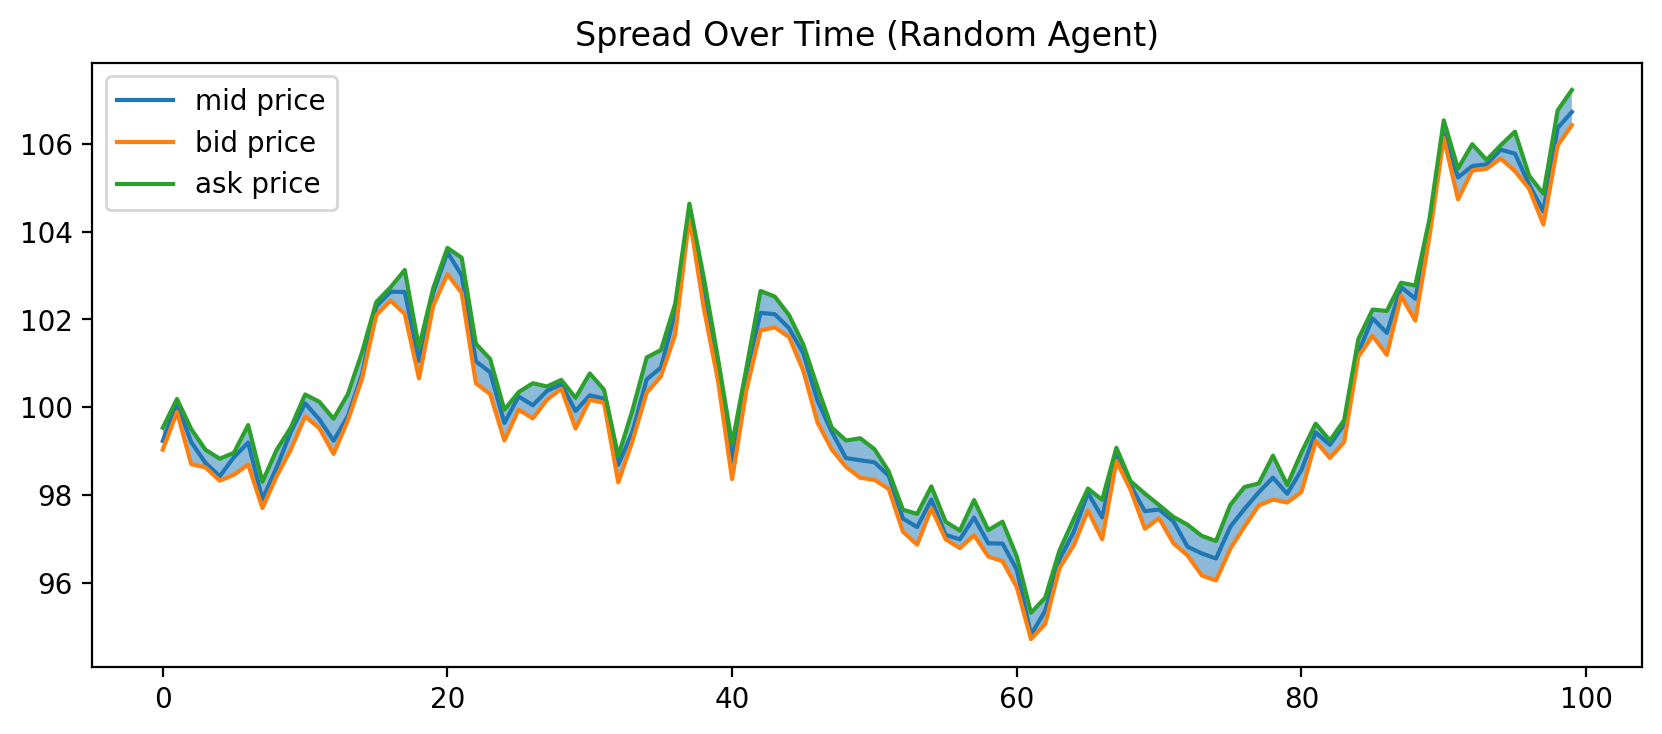

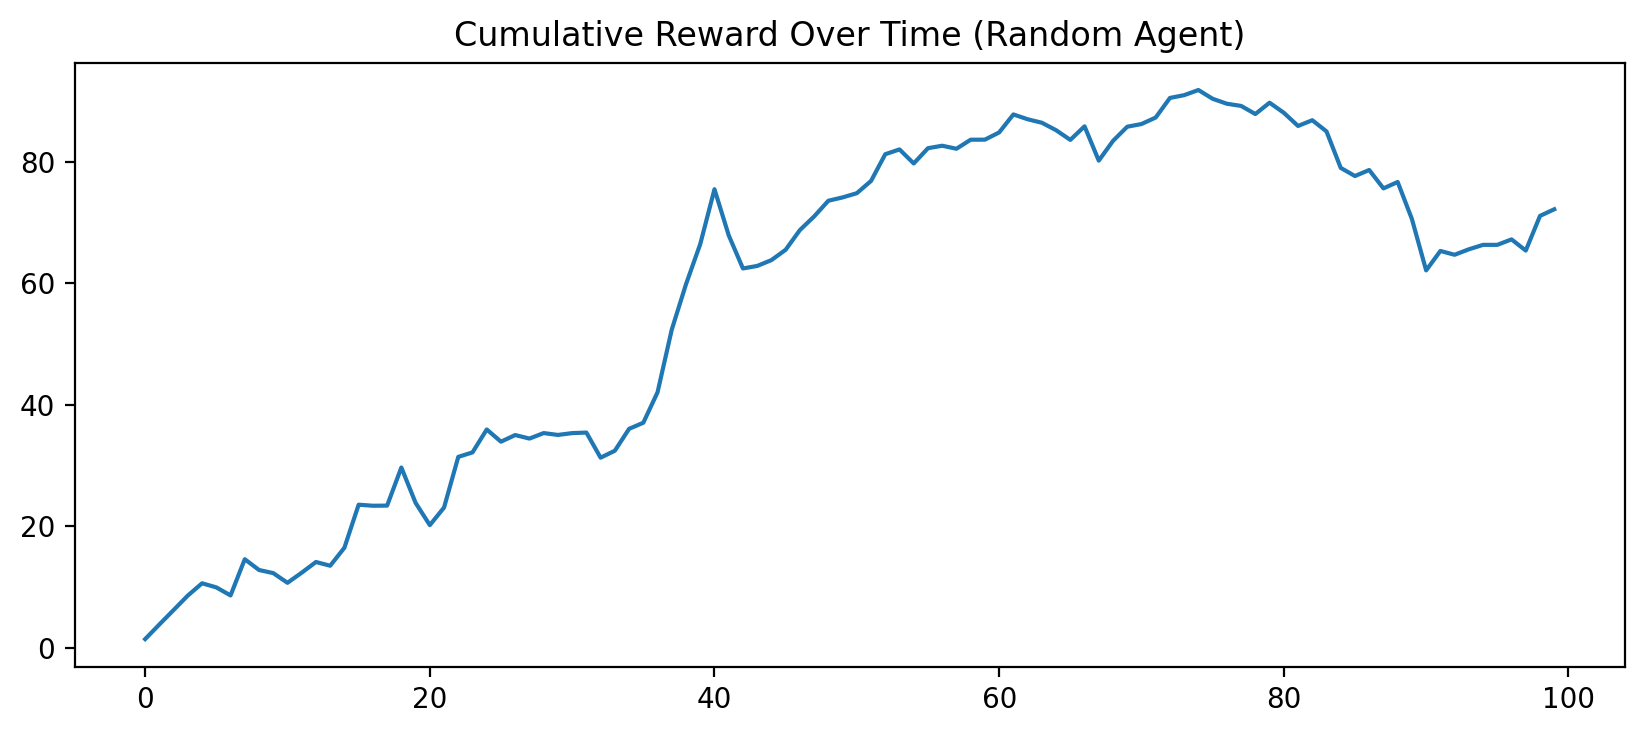

In [22]:
plot_single_experiemnt('Random Agent', mid_price, bid_price, ask_price, rewards)

## Q-Learning

In [23]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_Q = QAgent(env_d=env.d, env_Q=env.Q, env_T=env.T, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.3)

num_episodes = 2000
num_steps = 200

for episode in range(num_episodes):
    # Initialize
    env.reset()
    state = env.state()
    done = False
    total_reward = 0

    for step in range(num_steps):
        action = agent_Q.get_action(state)
        next_state, reward, done = env.step(action)
        agent_Q.update_Q(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break

    # Decay epsilon
    agent_Q.decay_epsilon()

    # Print episode results
    if (episode + 1) % 100 == 0:
        print(f'Episode: {episode + 1}, Total Reward: {total_reward}')

Episode: 100, Total Reward: 34.85349084870499
Episode: 200, Total Reward: 11.920782805996854
Episode: 300, Total Reward: 60.40280572501031
Episode: 400, Total Reward: 31.57640854952458
Episode: 500, Total Reward: 11.644116726284025
Episode: 600, Total Reward: 25.618722937305563
Episode: 700, Total Reward: 111.48479560485619
Episode: 800, Total Reward: 36.516978804955635
Episode: 900, Total Reward: 87.35917628391289
Episode: 1000, Total Reward: 47.97585381906096
Episode: 1100, Total Reward: -20.82478067010667
Episode: 1200, Total Reward: 61.492246988894706
Episode: 1300, Total Reward: 34.68061626150093
Episode: 1400, Total Reward: -40.6216048545201
Episode: 1500, Total Reward: 22.72111561286827
Episode: 1600, Total Reward: 38.03409778201665
Episode: 1700, Total Reward: -43.17397938510546
Episode: 1800, Total Reward: 56.322562320572146
Episode: 1900, Total Reward: 23.488424178681406
Episode: 2000, Total Reward: 36.06440205117083


In [24]:
rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
values = []
disc_reward = 0

env.reset()

while env.t < env.T:
    action = agent_Q.get_action(state)
    state, action_reward, done = env.step(np.array(action))
    disc_reward += action_reward
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    values.append(env.V_t)

opt_action = np.unravel_index(agent_Q.q_table[(0,0)].argmax(), agent_Q.q_table[(0,0)].shape)
Q_star = agent_Q.q_table[(0,0)][opt_action]

In [25]:
env.render()

--------------------
End of t = 100
Current mid price: 111.86
Current held volume: 0
Current held value: 0.0
Current cash process: -11.63
Current value process: -11.63
--------------------



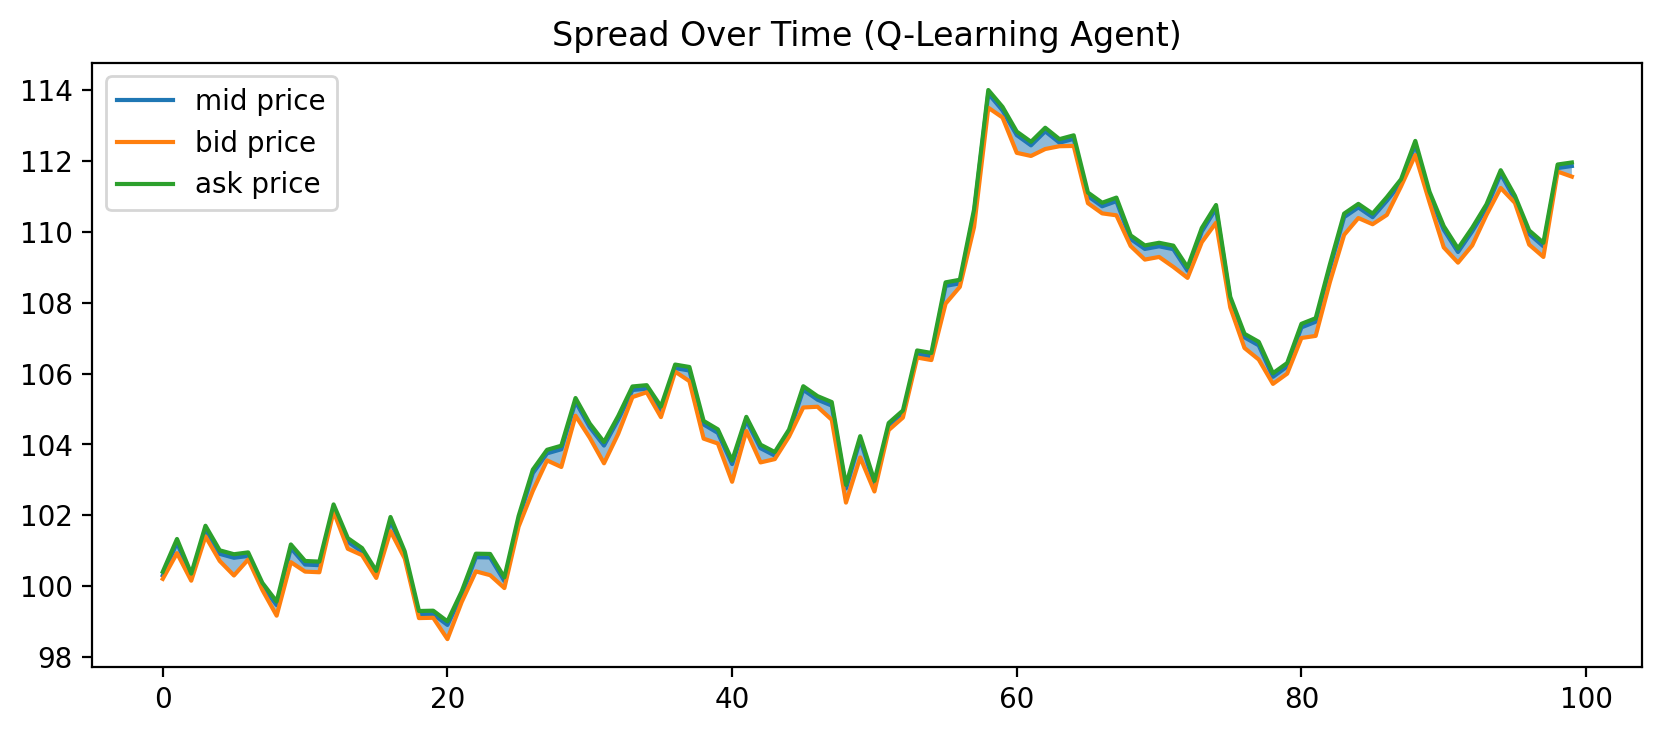

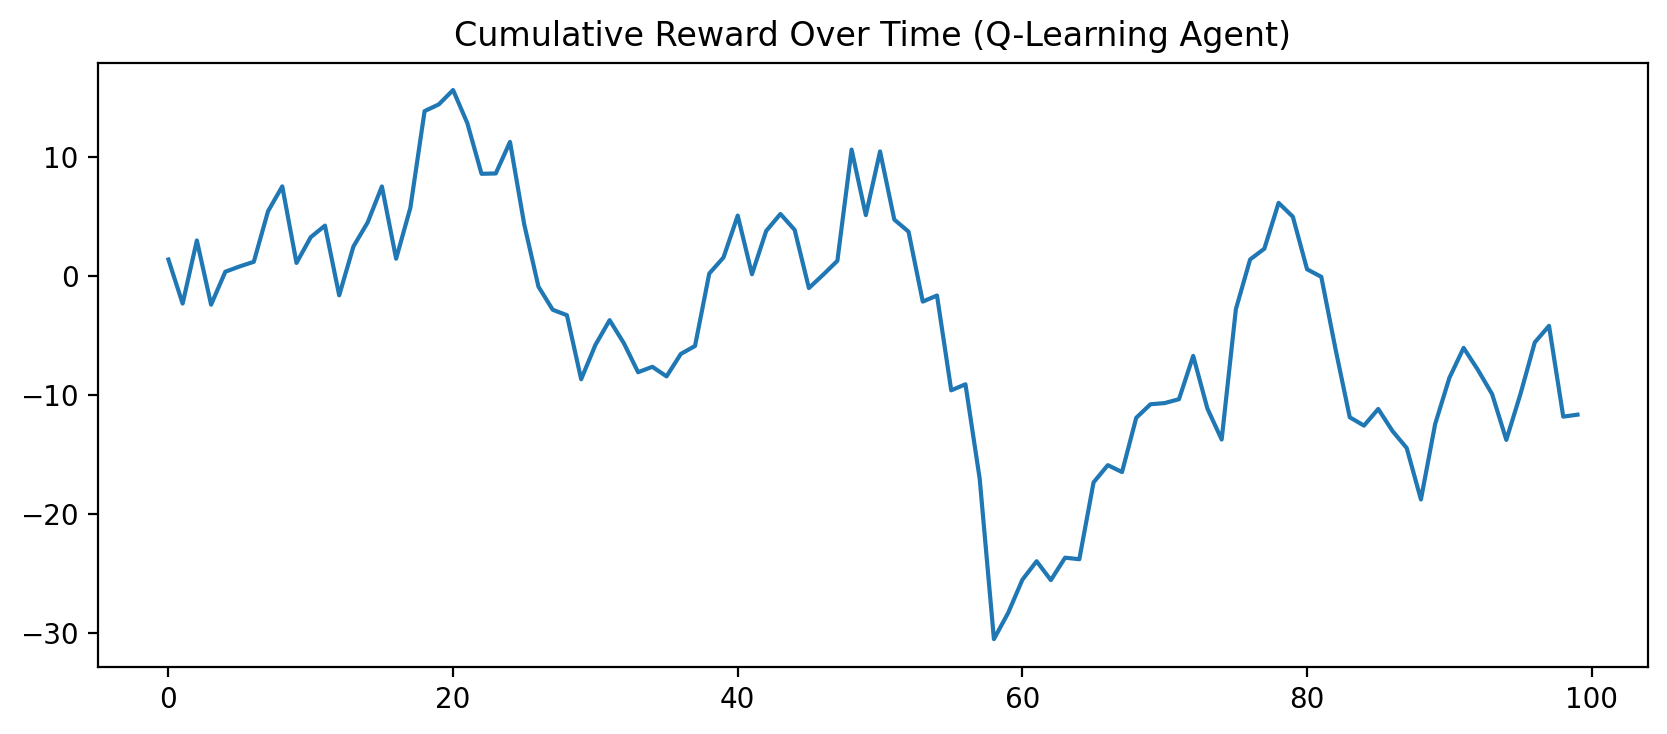

In [26]:
plot_single_experiemnt('Q-Learning Agent', mid_price, bid_price, ask_price, rewards)

# Multi-armed Bandit

## Explore First Agent

In [27]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_explorefirst = ExploreFirstAgent(num_actions_bid=5, num_actions_ask=5, max_explore=20)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_explorefirst.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_explorefirst.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [28]:
log_explorefirst = agent_explorefirst.get_log(show=False)
log_explorefirst.to_csv('./output/agent_explorefirst_log.csv', index=False)

In [29]:
env.render()

--------------------
End of t = 100
Current mid price: 94.92
Current held volume: 0
Current held value: 0.0
Current cash process: 81.93
Current value process: 81.93
--------------------



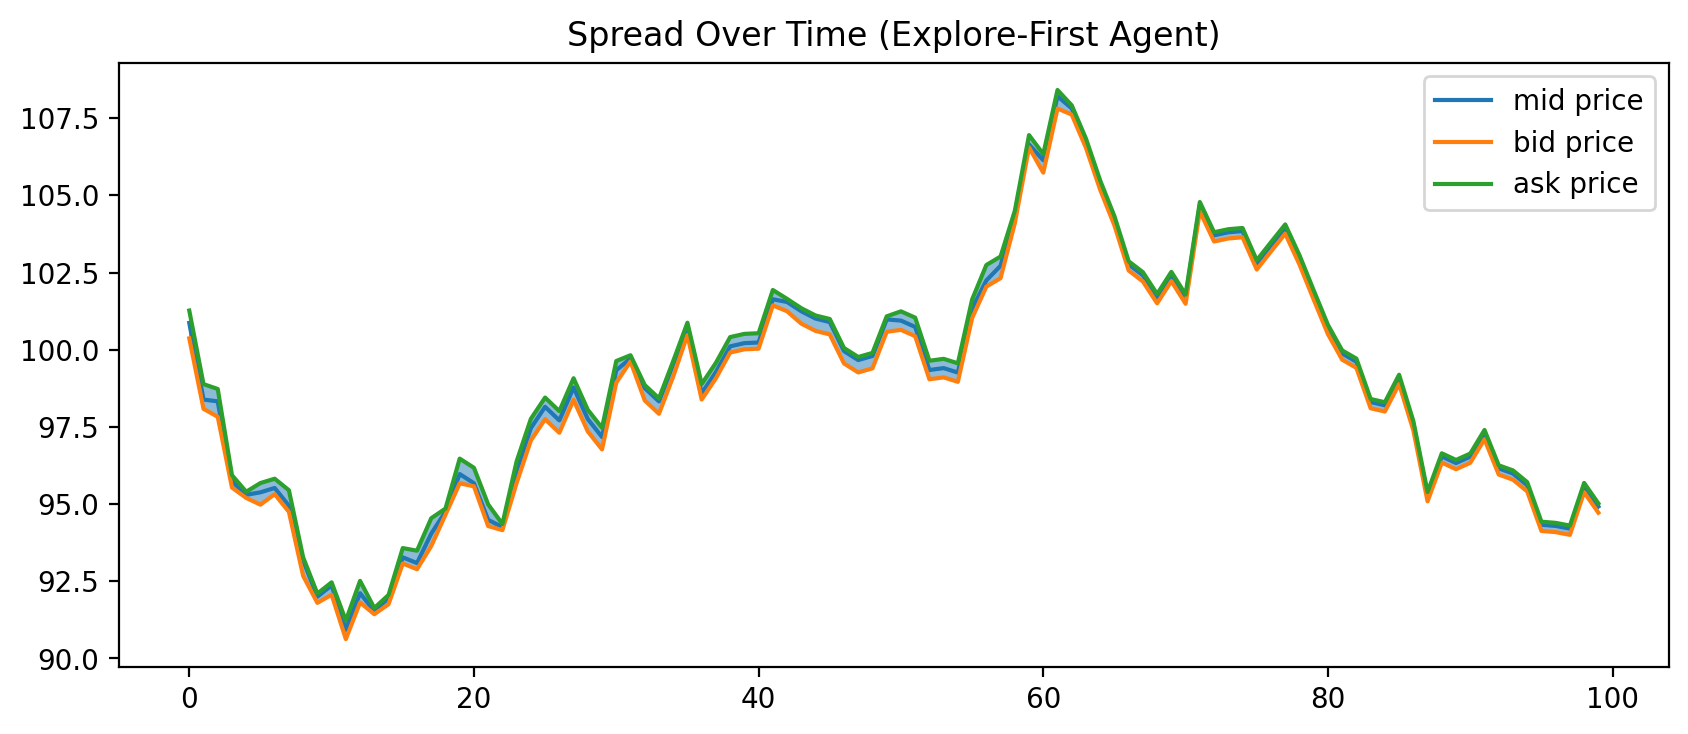

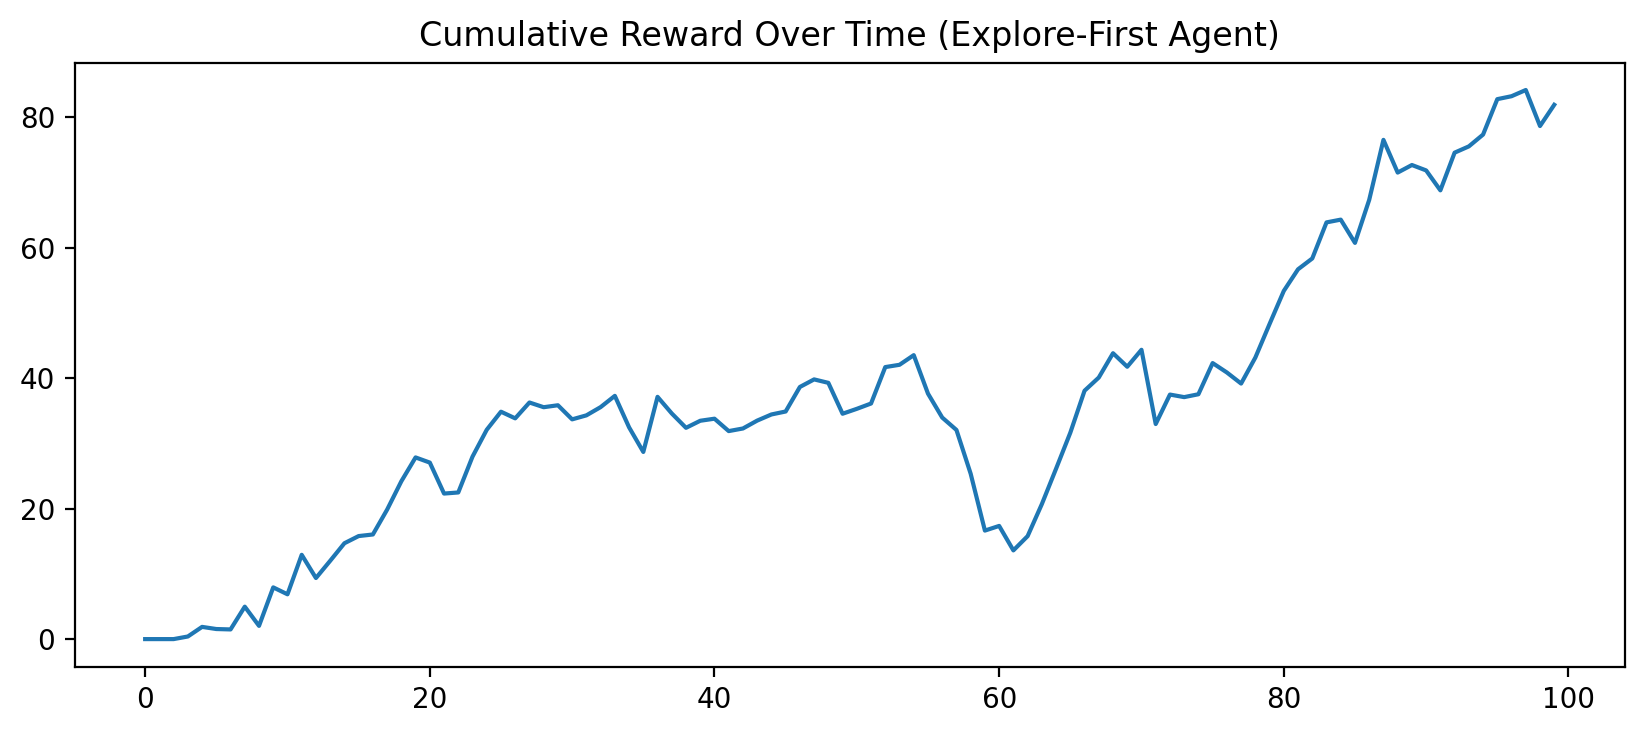

In [30]:
plot_single_experiemnt('Explore-First Agent', mid_price, bid_price, ask_price, rewards)

## UCB Agent

In [31]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_UCB = UCBAgent(num_actions_bid=5, num_actions_ask=5)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_UCB.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_UCB.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [32]:
log_UCB = agent_UCB.get_log(show=False)
log_UCB.to_csv('./output/agent_UCB_log.csv', index=False)

In [33]:
env.render()

--------------------
End of t = 100
Current mid price: 111.64
Current held volume: 0
Current held value: 0.0
Current cash process: -12.11
Current value process: -12.11
--------------------



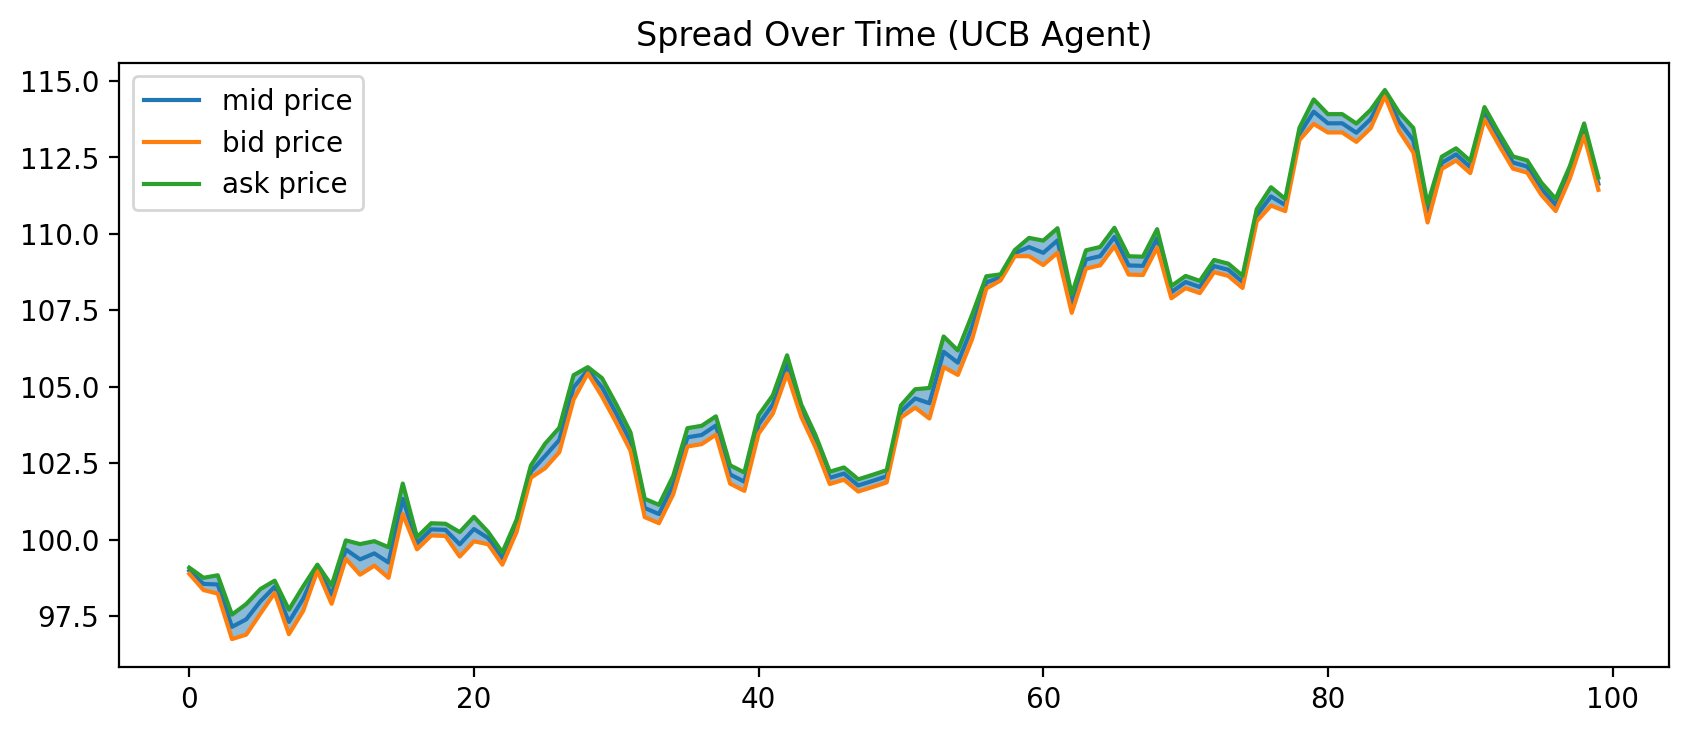

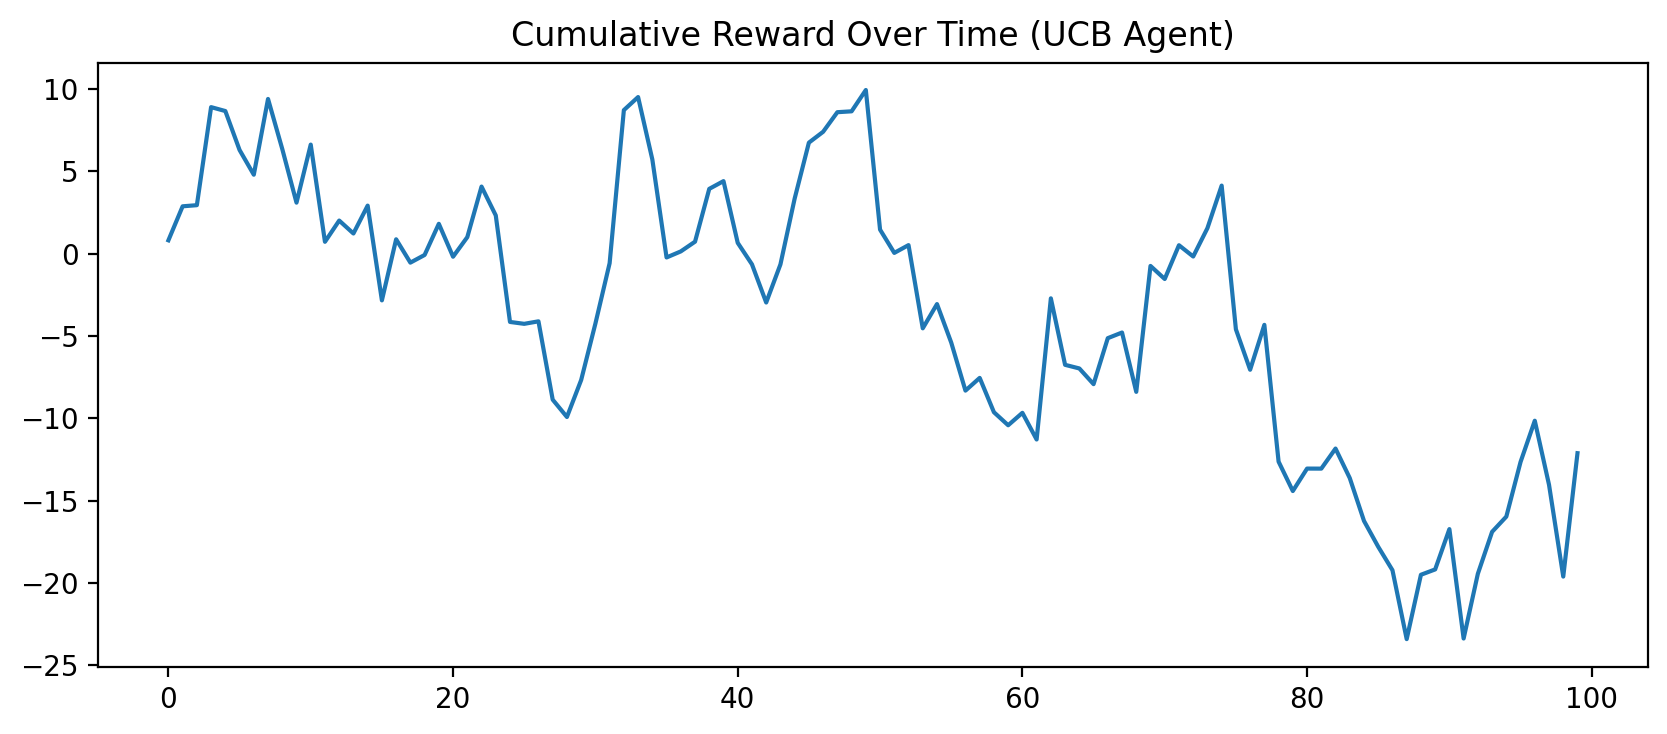

In [34]:
plot_single_experiemnt('UCB Agent', mid_price, bid_price, ask_price, rewards)

## Epsilon-Greedy Agent

In [35]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_epsilongreedy = EpsilonGreedyAgent(num_actions_bid=5, num_actions_ask=5, epsilon=0.1)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_epsilongreedy.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_epsilongreedy.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [36]:
log_epsilongreedy = agent_epsilongreedy.get_log(show=False)
log_epsilongreedy.to_csv('./output/agent_epsilongreedy_log.csv', index=False)

In [37]:
env.render()

--------------------
End of t = 100
Current mid price: 103.45
Current held volume: 0
Current held value: 0.0
Current cash process: 47.9
Current value process: 47.9
--------------------



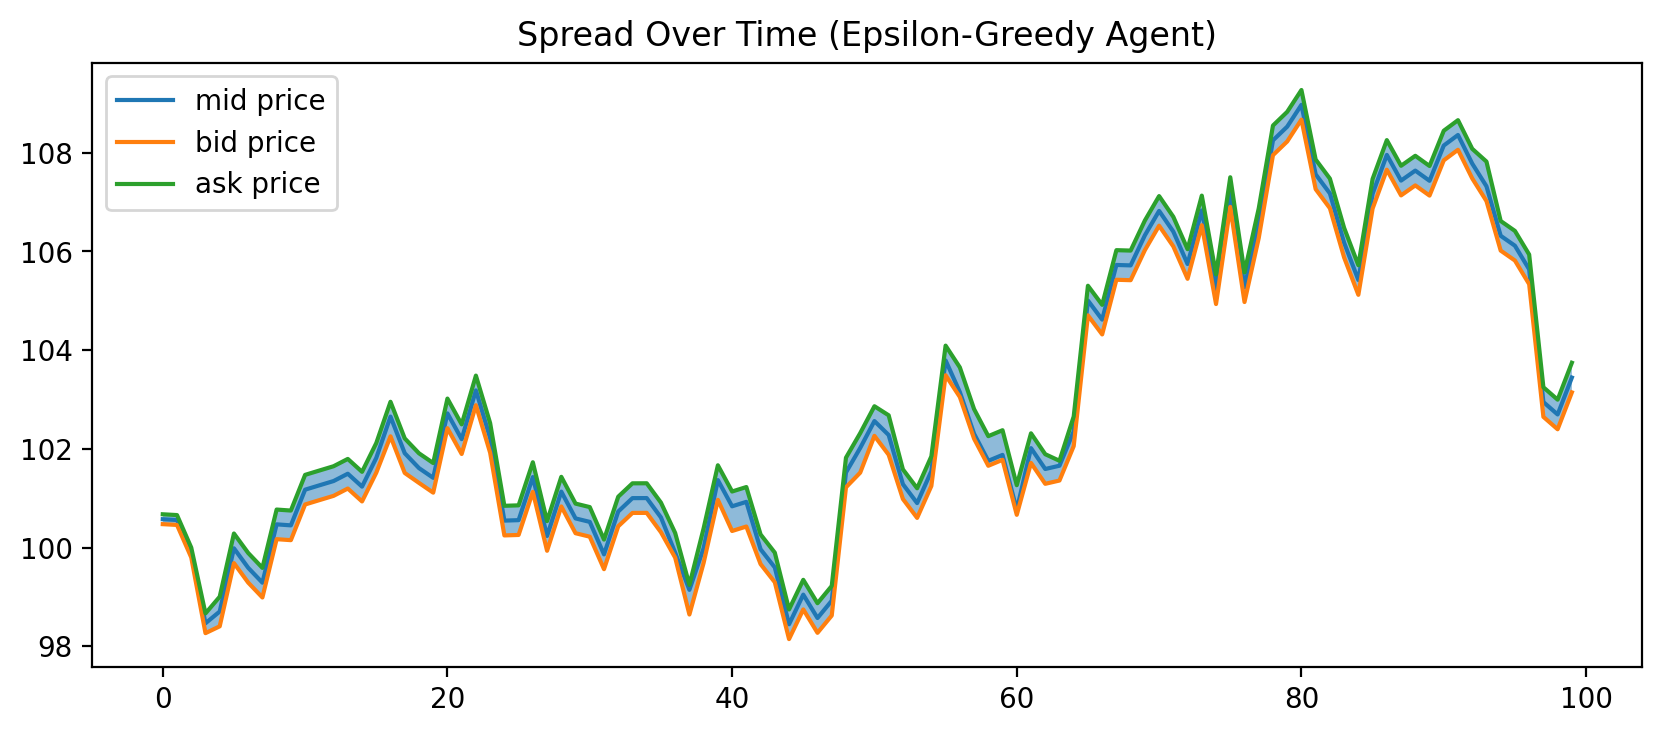

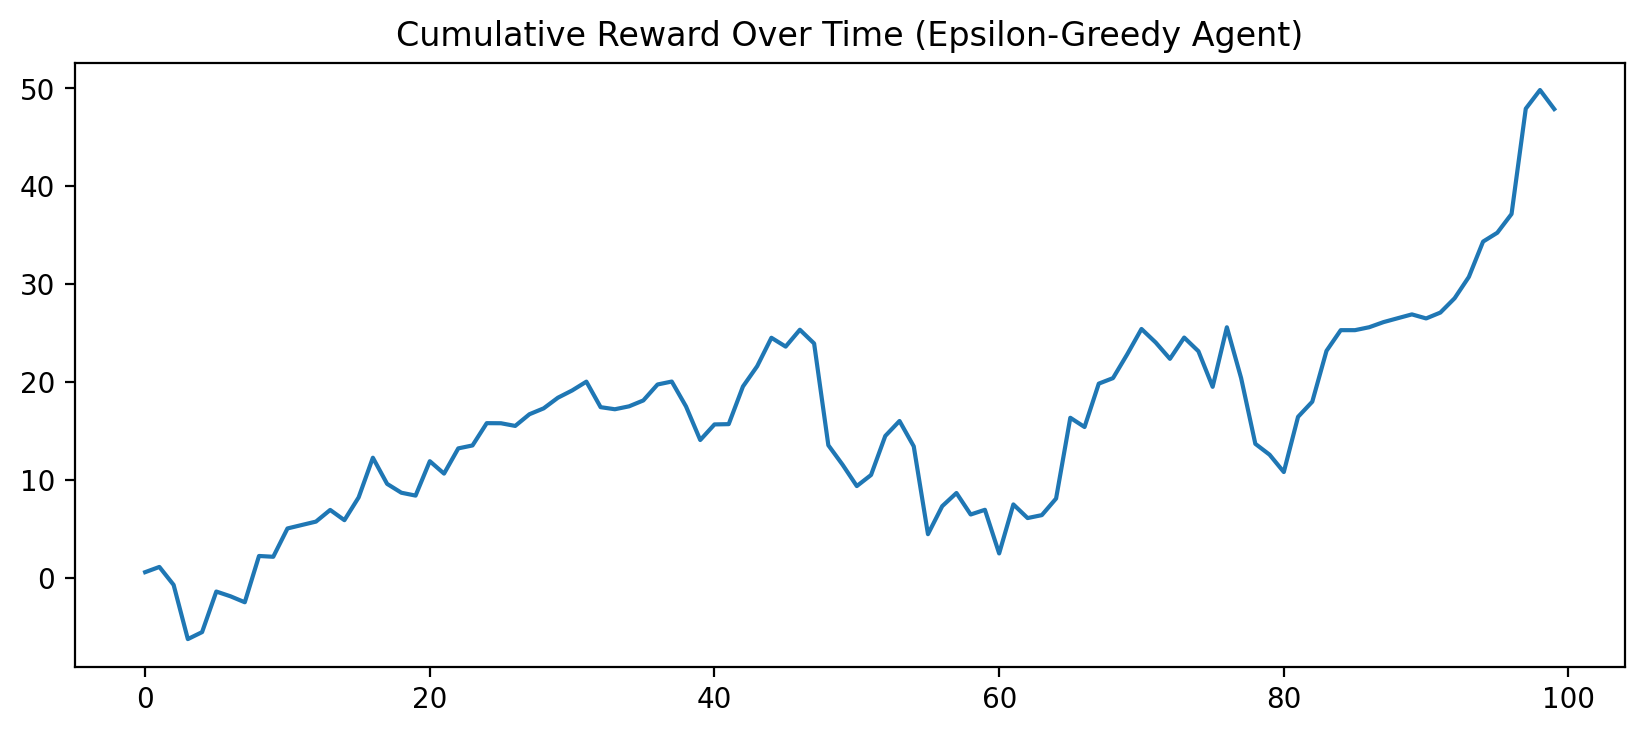

In [38]:
plot_single_experiemnt('Epsilon-Greedy Agent', mid_price, bid_price, ask_price, rewards)

# Mid-term Compare results

In [60]:
# record rewards
reward_random = []

In [61]:
for exp in range(100):

    env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
    rewards = []
    mid_price = []
    bid_price = []
    ask_price = []
    volume = []
    cash = []
    disc_reward = 0
    while env.t < env.T:
        action = env.action_space.sample()
        state, action_reward, done = env.step(np.array(action))
        disc_reward += action_reward  
        rewards.append(disc_reward)
        mid_price.append(env.mid)
        bid_price.append(env.mm_bid)
        ask_price.append(env.mm_ask)
        volume.append(state[0])
        cash.append(env.X_t)

    reward_random.append(rewards[-1])
    print(f"Random startegy {exp+1}, final reward {rewards[-1]}")

Random startegy 1, final reward 50.180561228414085
Random startegy 2, final reward 19.479914711185387
Random startegy 3, final reward 50.383757588972514
Random startegy 4, final reward -14.867577654272997
Random startegy 5, final reward 39.108859980280116
Random startegy 6, final reward -10.11425494753537
Random startegy 7, final reward 36.2810705133293
Random startegy 8, final reward 72.89455309237653
Random startegy 9, final reward 41.81496509697287
Random startegy 10, final reward 31.882164236408883
Random startegy 11, final reward -2.5662054160838643
Random startegy 12, final reward 90.41174121186027
Random startegy 13, final reward -16.003626605059264
Random startegy 14, final reward 109.22926332137507
Random startegy 15, final reward 49.36866306675233
Random startegy 16, final reward 111.65862059675716
Random startegy 17, final reward 37.33348406212663
Random startegy 18, final reward 44.11678346992395
Random startegy 19, final reward 58.535257885735504
Random startegy 20, final 

In [78]:
# Record rewards with different epsilon_decay
# reward_Q_eps = {}
# reward_Q_eps

In [89]:
reward_Q_tmp = []

for exp in range(1):

    ## Train

    # Hyperparameters
    learning_rate = 0.1
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.3
    num_episodes = 2000
    num_steps = 200

    # Create the environment
    env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

    # Initialize Q-table
    q_table = {(i, j): np.zeros((env.d, env.d)) for i in range(-env.Q, env.Q + 1) for j in range(env.T + 1)}

    for episode in range(num_episodes):
        # print(f"episode {episode}")
        env.reset()
        state = env.state()
        done = False
        total_reward = 0

        for step in range(num_steps):
            action = choose_action(state, epsilon)
            next_state, reward, done = env.step(action)
            # print(f"    {step} step: state={state}, epsilon={epsilon}, action={action}, reward={reward}")

            # Update Q-table
            #q_table[state][action] = (1 - learning_rate) * q_table[state][action] + learning_rate * (reward + gamma * (np.max(q_table[next_state])) - q_table[state][action]))
            q_table[state][action] += learning_rate * ((reward + gamma * (np.max(q_table[next_state]))) - q_table[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon - epsilon_decay)

        # Print episode results
        if (episode + 1) % 1000 == 0:
            print(f'  Episode: {episode + 1}, Total Reward: {total_reward}')

    # Test
    rewards = []
    mid_price = []
    bid_price = []
    ask_price = []
    volume = []
    values = []
    disc_reward = 0

    env.reset()

    while env.t < env.T:
        action = np.array(np.unravel_index(q_table[state].argmax(), q_table[state].shape))
        state = env.state()
        state, action_reward, done = env.step(np.array(action))

        disc_reward += action_reward
        rewards.append(disc_reward)
        mid_price.append(env.mid)
        bid_price.append(env.mm_bid)
        ask_price.append(env.mm_ask)
        volume.append(state[0])
        values.append(env.V_t)

    opt_action = np.unravel_index(q_table[(0,0)].argmax(), q_table[(0,0)].shape)
    Q_star = q_table[(0,0)][opt_action]

    reward_Q_tmp.append(rewards[-1])
    print(f"Q-learning startegy {exp+1}, final reward {rewards[-1]}")

# record rewards
# reward_Q_eps[epsilon_decay] = reward_Q_tmp

  Episode: 1000, Total Reward: -52.34143010402451
  Episode: 2000, Total Reward: -5.82491137489468
Q-learning startegy 1, final reward 70.08194070592175


In [83]:
for key in reward_Q_eps.keys():
    
    print(f"epsilon_decay = {key}, final reward = {np.mean(reward_Q_eps[key])}")

epsilon_decay = 0.995, final reward = 28.867104140663066
epsilon_decay = 0.2, final reward = 29.788505844947586
epsilon_decay = 0.1, final reward = 27.742229644483313
epsilon_decay = 0.01, final reward = 25.148243663889428
epsilon_decay = 0.3, final reward = 62.5798074752647


In [98]:
import pandas as pd

result_df = pd.DataFrame({"Random": reward_random[:10],
                          "Q-learning": reward_Q_eps[0.3]
                          })
result_df.describe()

,Random,Q-learning
count,10.000000,10.000000
mean,31.704401,62.579807
std,27.145963,35.507317
min,-14.867578,15.965942
25%,22.580477,35.053931
50%,37.694965,62.304556
75%,48.089162,80.687017
max,72.894553,137.043167


In [99]:
env.render()

--------------------
End of t = 100
Current mid price: 88.82
Current held volume: 0
Current held value: 0.0
Current cash process: 70.1
Current value process: 70.1
--------------------



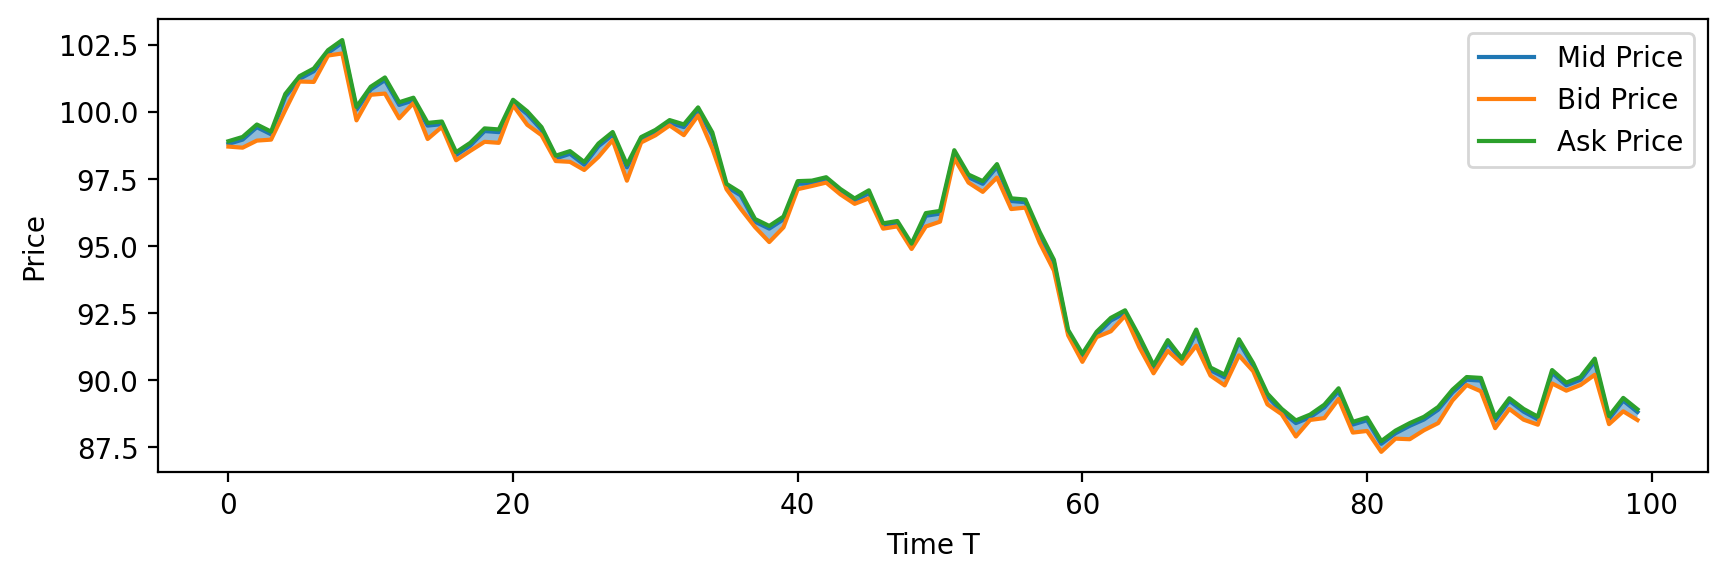

In [100]:
plt.figure(figsize=(10,3), dpi=200)
plt.plot(mid_price, label='Mid Price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='Bid Price')
plt.plot(ask_price, label='Ask Price')
plt.xlabel("Time T")
plt.ylabel("Price")
plt.legend()
# plt.title('Spread Over Time (Q-learning)')
plt.show()

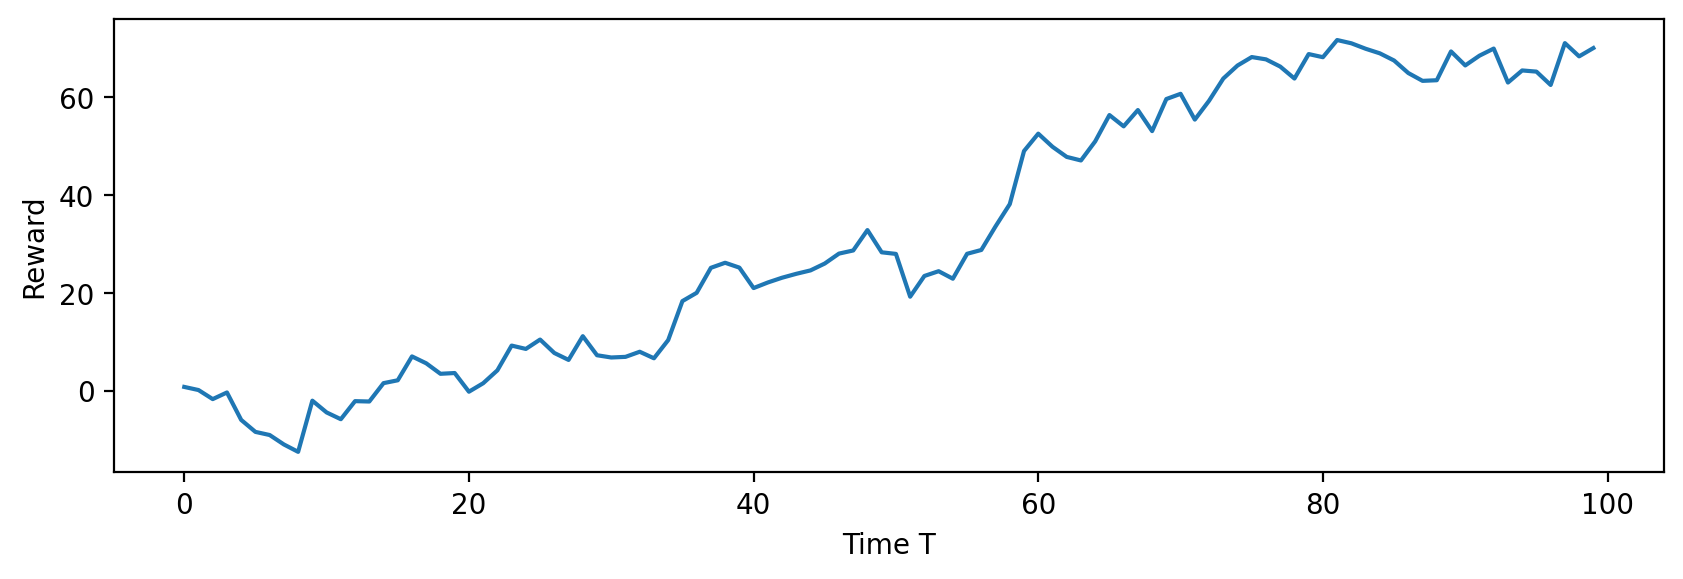

In [101]:
#plot rewards
plt.figure(figsize=(10,3), dpi=200)
plt.plot(rewards)
# plt.title('Cumulative Reward Over Time (Q-learning)')
plt.xlabel("Time T")
plt.ylabel("Reward")
plt.show()